In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h1> A Markov matrix (or stochastic matrix) </h1>

<p> Gives the probability of reaching a set of states given a set of starting states. Here's a basic example of what such a Markov chain would look if we wanted to model the weather in the evening given the weather in the morning: </p>

<img src="markov.png">

The starting "state" is listed on the left, while the column gives the final outcome. If we wanted to know the probability of Evening Sun given that it there was Morning rain, we would get 0.25 - a 25% chance of that outcome. Note that each row of this matrix is normalized, a statement that if you start in a state, there is a 100% chance that something happens. Nothing tricky here.

In [2]:
np.random.seed(30)
characters = list('abcdefghijklmnopqrstuvwxyz ')
cipher     = np.random.permutation(characters)

state_space = len(characters)
state_space

27

In [3]:
# take jumbled code to english
correct_map  = {code:   actual for code, actual in zip(cipher, characters)}
# take english to jumbled code
jumbler      = {actual: code for code, actual in correct_map.items()}
# indices of correct english
alpha_lookup = {letter: i for i, letter in enumerate(characters)}

In [4]:
def clean_chapter(doc):
    intermediate = re.sub(r'[^a-z]', ' ', doc)  
    return re.sub(r"\s\s+", " ", intermediate)

def combine_chapters(chapters):
    docs = [np.loadtxt(f'./moby_dick/chapter_{chap}.txt', dtype=str) for chap in chapters]
    docs = [" ".join(doc) for doc in docs]
    docs = [clean_chapter(doc) for doc in docs]
    return " ".join(docs)

#### The reference text is taken to be the first ~40 chapters of Moby Dick. We look to predict on chapters 50 and 60.

In [5]:
train_chapters = combine_chapters(np.arange(1, 40))
test_chapters  = combine_chapters([50, 60])

test_chapters[:100]

'chapter the hyena there are certain queer times and occasions in this strange mixed affair we call l'

In [6]:
def make_cooccurrence_matrix(corpus, smooth_factor=1./state_space):
    """
    Matrix of counts
    
    first index is starting char, 
    second is following char
    """
    counts = np.zeros(shape=(state_space, state_space))
    last = None
    for index, char in enumerate(corpus):
        if index == 0:
            last = alpha_lookup[char]
            continue
            
        current = alpha_lookup[char]
        counts[last, current] += 1
        last = current
    
    return counts + smooth_factor

def make_transition_matrix(corpus, smooth_factor=1./state_space):
    """
    Normalized cooccurrence matrix -> empirical transition matrix
    """
    mx = make_cooccurrence_matrix(corpus, smooth_factor)
    total_ocs = np.sum(mx, axis=1).reshape(-1, 1)
    return mx / total_ocs

In [7]:
transition_matrix = make_transition_matrix(train_chapters)

#### This is what the reference transition matrix, T, looks like.


In [8]:
transition_df = pd.DataFrame(transition_matrix)
transition_df.columns = characters
transition_df.index   = characters
assert np.all(np.isclose(transition_df.sum(axis=1), 1.0)), "transition matrix should be normalized by row"
transition_df.head()

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,
a,0.000090,0.028496,0.029420,0.038434,0.000617,0.007961,0.020933,0.009984,0.045734,0.000221,...,0.097007,0.089663,0.126337,0.006774,0.022780,0.009016,0.000485,0.027705,0.002420,0.081616
b,0.065578,0.018742,0.000008,0.000424,0.267493,0.000008,0.000008,0.000008,0.051840,0.003546,...,0.052464,0.016036,0.006669,0.158209,0.001049,0.000008,0.000008,0.068076,0.000008,0.040599
c,0.145010,0.000006,0.015508,0.000006,0.155659,0.000006,0.000006,0.168813,0.046984,0.000006,...,0.046827,0.001102,0.049802,0.030541,0.000006,0.000006,0.000006,0.005330,0.000789,0.017857
d,0.027830,0.000003,0.000092,0.009160,0.122781,0.003559,0.003559,0.000270,0.066059,0.000359,...,0.017695,0.031209,0.000270,0.009427,0.002226,0.000981,0.000003,0.009072,0.000003,0.624470
e,0.052742,0.001399,0.014904,0.079098,0.045216,0.007854,0.013357,0.002649,0.010948,0.000239,...,0.129102,0.068984,0.029837,0.000715,0.016689,0.006664,0.005980,0.010353,0.000239,0.354435


In [9]:
# these should be about the same (up to a smoothing factor)
# this is the fraction of times 'b' follows 'a'
transition_matrix[0, 1], train_chapters.count('ab') / train_chapters.count('a')

(0.028496417793282488, 0.02849604221635884)

# Metropolis Step

The acceptance probability of a proposed cipher can be calculated as:

$$
\begin{align}
P(accept)\ =\ min(1, \frac{\pi(x^*)Q(x -> x^*)}{\pi(x)Q(x* -> x)} )
\end{align}
$$

In our case, the proposed cipher is generated by randomly swapping two characters in the cipher. This means that the odds of proposing a cipher are symmetric, so the ratio of Qs is just 1. This means that the probability of accepting a cipher is,

$$
\begin{align}
P(accept)\ =\ min(1, \frac{\pi(x^*)}{\pi(x)} )
\end{align}
$$

Where $\pi(x)$ indicates the probability of observation `x` under the target distribution using its respective cipher. We take the target distribution to be the empirical transition matrix of some reference text, which we call `T`. This means that the log-likelihood of a deciphered observation under the target distribution is approximately,

$$
\begin{align}
LL(x) \approx \sum_{i=1}^{len(x)} T[word_{i - 1}, word_{i}]
\end{align}
$$

This is only approximate because it ignores the probability of the first character, but the advantage is that the likelihood can be efficiently calculated with a our cooccurence matrix. The overall likelihood is simply the sum of the log transition matrix multiplied by the cooccurrence (count) matrix.

In [10]:
def logprob(train_transition_matrix, observation):
    observed_counts = make_cooccurrence_matrix(observation, smooth_factor=0)
    i, j = np.where(observed_counts > 0)
    return np.sum(np.log(train_transition_matrix[i, j]) * observed_counts[i, j])

In [11]:
logprob(transition_matrix, train_chapters), logprob(transition_matrix, test_chapters)

(-782418.2145711083, -23044.78347109547)

In [12]:
def decipher_string(ciphered_string, decoder):
    """
    Decode a ciphered text.
    
    Decoder: dict mapping {ciphered char: unciphered char}
    """
    new_str = ''
    
    for char in ciphered_string:
        new_str += decoder[char]
        
    return new_str

def cipher_message(unciphered_string, encoder):
    return decipher_string(unciphered_string, encoder)

In [13]:
def propose_cipher(original_cipher):
    """
    Swap two elements of the cipher at random
    
    Since this is done uniformly over letters, 
    the acceptance probability is easy to calculate 
    """
    new_cipher = original_cipher.copy()
    char1, char2 = np.random.choice(characters, size=2, replace=False)
    
    char1_val = original_cipher[char1]
    char2_val = original_cipher[char2]
    
    new_cipher[char1] = char2_val
    new_cipher[char2] = char1_val
    
    return new_cipher

In [14]:
start_cipher = {ciph: actual for actual, ciph in 
                zip(np.random.choice(characters, size=27, replace=False), np.random.choice(characters, size=state_space, replace=False))}
ciphered_doc = cipher_message(test_chapters, start_cipher)

In [15]:
print('We want to recover:\n->',      test_chapters[:100], '...')
print('\nFrom the jumbled text:\n->', ciphered_doc[:100],  '...')

We want to recover:
-> chapter the hyena there are certain queer times and occasions in this strange mixed affair we call l ...

From the jumbled text:
-> sthrlqpgltqgtxqkhgltqpqghpqgsqplhwkgceqqpglwzq ghkmgassh wak gwkgltw g lphkdqgzwuqmghoohwpgiqgshbbgb ...


In [16]:
def accept_proposed_cipher(proposed_loglike, original_loglike):
    prob_ratio = np.exp(proposed_loglike - original_loglike)
    uniform_random = np.random.random()
    
    return prob_ratio > uniform_random

In [17]:
n_iterations = 2500
current_cipher = start_cipher
likes = []

for cycle in range(n_iterations):
    """
    MCMC steps:

    1) pick random cipher
    
    Until convergence/n iterations:
        2) decode text
        3) calculate log likelihood
        4) use MH criterion to decide whether to keep new cipher
        
    """
    prop_cipher = propose_cipher(current_cipher)
    prop_decoded_text = decipher_string(ciphered_doc, prop_cipher)
    
    if cycle % 50 == 0:
        print(f"\nCycle {cycle}:", prop_decoded_text[:100])
        
    og_decoded_text = decipher_string(ciphered_doc, current_cipher)
    
    prop_loglike = logprob(transition_matrix, prop_decoded_text)
    og_loglike   = logprob(transition_matrix, og_decoded_text)
    
    if accept_proposed_cipher(proposed_loglike=prop_loglike, original_loglike=og_loglike):
        current_cipher = prop_cipher
        likes += [prop_loglike]
    else:
        likes += [og_loglike]

print(f"\n Final Cycle:", prop_decoded_text[:100])


Cycle 0:  ltpbcrdblcdlucvtdblcrcdtrcd crbtivdsqccrdbifcgdtvzdy  tgiyvgdivdbligdgbrtvmcdfieczdtaatirdwcd thhdh


/anaconda2/envs/dsm_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



Cycle 50: tc fqiruqciucdih uqciriu riutirq ahunoiiruqabilu hzuytt layhluahuqcalulqr hmiubagizu pp arujiut ssus

Cycle 100: nrefuic uri rhipe urici eci nicueap toiic uazil epb ynnelaypl ap ural lucepmi zakib eddeac ji ness s

Cycle 150: nwabtir twi wkipa twiri ari nirtaep moiir tezis apf ynnaseyps ep twes strapui zevif addaer hi nall l

Cycle 200: dwabtir twi wkina twiri ari dirtaen uoiir tezis anf yddaseyns en twes stranji zexif appaer hi dall l

Cycle 250: dyabtir tyi yfioa tyiri ari dirtaeo wniir temis aok uddaseuos eo tyes straogi mexik appaer hi dall l

Cycle 300: kwabtir twi wfina twiri ari kirtaen zoiir temis and ukkaseuns en twes strangi meqid appaer hi kall l

Cycle 350: fwabtir twi wkina twiri ari firtaen zuiir temis and xffasexns en twes strangi meoid appaer hi fall l

Cycle 400: ph btirathiahkin athiria riapirt enaquiiratemisa ndaopp seonsaenathesastr ngiamexida ff erawiap llal

Cycle 450: pjabter tje jkena tjere are pertain queer times and oppasions in tjis strange mixed a

In [18]:
decipher_string(ciphered_doc, current_cipher)

'chapter the hyena there are certain queer times and occasions in this strange mixed affair we call life when a man takes this whole universe for a vast practical joke though the wit thereof he but dimly discerns and more than suspects that the joke is at nobody s expense but his own however nothing dispirits and nothing seems worth while disputing he bolts down all events all creeds and beliefs and persuasions all hard things visible and invisible never mind how knobby as an ostrich of potent digestion gobbles down bullets and gun flints and as for small difficulties and worryings prospects of sudden disaster peril of life and limb all these and death itself seem to him only sly good natured hits and jolly punches in the side bestowed by the unseen and unaccountable old joker that odd sort of wayward mood i am speaking of comes over a man only in some time of extreme tribulation it comes in the very midst of his earnestness so that what just before might have seemed to him a thing mos

In [19]:
print('\nActual doc:\n', test_chapters[:100])
print('\nCiphered doc:\n', ciphered_doc[:100])


Actual doc:
 chapter the hyena there are certain queer times and occasions in this strange mixed affair we call l

Ciphered doc:
 sthrlqpgltqgtxqkhgltqpqghpqgsqplhwkgceqqpglwzq ghkmgassh wak gwkgltw g lphkdqgzwuqmghoohwpgiqgshbbgb


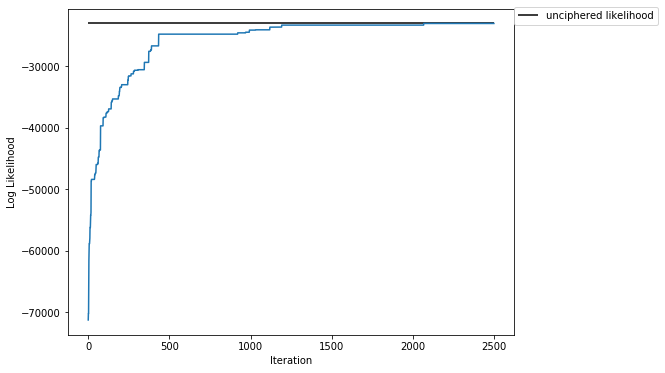

In [20]:
actual_loglike = logprob(transition_matrix, test_chapters)

plt.figure(figsize=(8, 6))
plt.plot(likes)
plt.hlines(actual_loglike, 0, n_iterations, label='unciphered likelihood')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.legend(loc=[1, 0.95]);

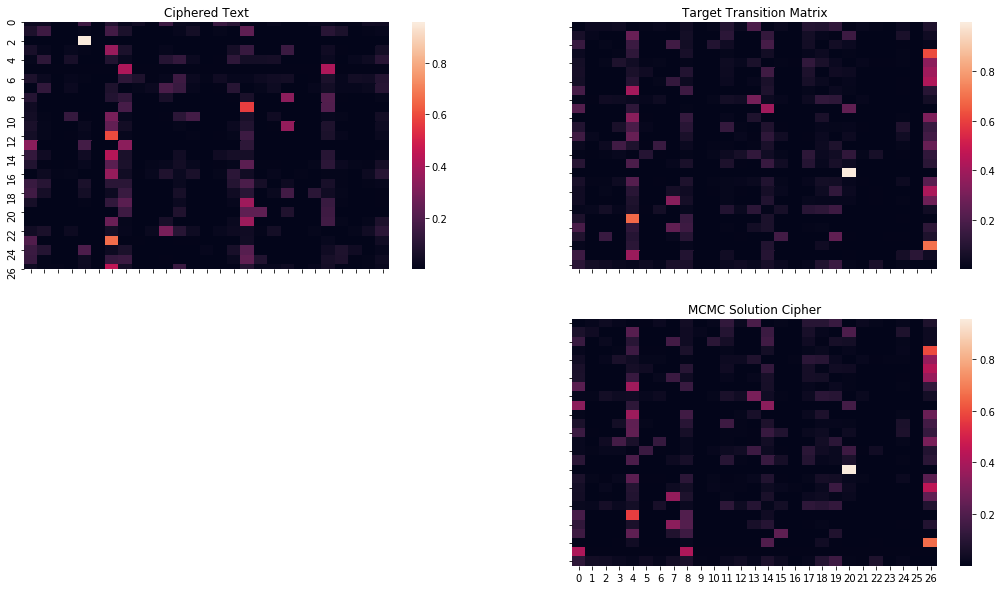

In [21]:
f, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True)

cipher_axes   = (0, 0)
target_axes   = (0, 1)
solution_axes = (1, 1) 

# target
sns.heatmap(transition_matrix, ax=axes[target_axes])
# solution
sns.heatmap(make_transition_matrix(corpus=decipher_string(ciphered_doc, current_cipher)), ax=axes[solution_axes])
# Ciphered
sns.heatmap(make_transition_matrix(corpus=ciphered_doc), ax=axes[cipher_axes])

axes[target_axes].set_title('Target Transition Matrix')
axes[solution_axes].set_title('MCMC Solution Cipher');
axes[cipher_axes].set_title('Ciphered Text')

axes[1,0].remove()